In [1]:
!nvidia-smi

Fri Jul 14 01:22:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Python/Bearing Faults Project'

Mounted at /content/drive
/content/drive/MyDrive/Python/Bearing Faults Project


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from random import randint
import utils
import time
#import utils_lenet5
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
bs = 1

cuda


#preprocessing

In [4]:
training_samples = 60
split = training_samples//30

In [5]:
import os,re
import errno
import random
import urllib.request as urllib
import numpy as np
from scipy.io import loadmat
from sklearn.utils import shuffle

def fliter_key(keys):
    fkeys = []
    for key in keys:
        matchObj = re.match( r'(.*)FE_time', key, re.M|re.I)
        if matchObj:
            fkeys.append(matchObj.group(1))
    if(len(fkeys)>1):
        print(keys)
    return fkeys[0]+'DE_time',fkeys[0]+'FE_time'


exps_idx = {
    '12DriveEndFault':0,
    '12FanEndFault':9,
    '48DriveEndFault':0
}

faults_idx = {
    'Normal': 0,
    '0.007-Ball': 1,
    '0.014-Ball': 2,
    '0.021-Ball': 3,
    '0.007-InnerRace': 4,
    '0.014-InnerRace': 5,
    '0.021-InnerRace': 6,
    '0.007-OuterRace6': 7,
    '0.014-OuterRace6': 8,
    '0.021-OuterRace6': 9,
#     '0.007-OuterRace3': 10,
#     '0.014-OuterRace3': 11,
#     '0.021-OuterRace3': 12,
#     '0.007-OuterRace12': 13,
#     '0.014-OuterRace12': 14,
#     '0.021-OuterRace12': 15,
}

def get_class(exp,fault):
    if fault == 'Normal':
        return 0
    return exps_idx[exp] + faults_idx[fault]


class CWRU:
    def __init__(self, exps, rpms, length):
        for exp in exps:
            if exp not in ('12DriveEndFault', '12FanEndFault', '48DriveEndFault'):
                print("wrong experiment name: {}".format(exp))
                return
        for rpm in rpms:
            if rpm not in ('1797', '1772', '1750', '1730'):
                print("wrong rpm value: {}".format(rpm))
                return
        # root directory of all data
        rdir = os.path.join('Datasets/CWRU')
        print(rdir,exp,rpm)

        fmeta = os.path.join(os.path.dirname('__file__'), 'metadata.txt')
        all_lines = open(fmeta).readlines()
        all_lines = open(fmeta).readlines()
        lines = []
        for line in all_lines:
            l = line.split()
            if (l[0] in exps or l[0] == 'NormalBaseline') and l[1] in rpms:
                if 'Normal' in l[2] or '0.007' in l[2] or '0.014' in l[2] or '0.021' in l[2]:
                    if faults_idx.get(l[2],-1)!=-1:
                        lines.append(l)

        self.length = length  # sequence length
        lines = sorted(lines, key=lambda line: get_class(line[0],line[2]))
        self._load_and_slice_data(rdir, lines)
        # shuffle training and test arrays
        self._shuffle()
        self.all_labels = tuple(((line[0]+line[2]),get_class(line[0],line[2])) for line in lines)
        self.classes = sorted(list(set(self.all_labels)), key=lambda label: label[1])
        self.nclasses = len(self.classes)  # number of classes

    def _mkdir(self, path):
        try:
            os.makedirs(path)
        except OSError as exc:
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                print("can't create directory '{}''".format(path))
                exit(1)

    def _download(self, fpath, link):
        print(link + " Downloading to: '{}'".format(fpath))
        urllib.urlretrieve(link, fpath)

    def _load_and_slice_data(self, rdir, infos):
        self.X_train = np.zeros((0, self.length, 2))
        self.X_test = np.zeros((0, self.length, 2))
        self.y_train = []
        self.y_test = []
        train_cuts = list(range(0,60000,80))[:split]
        test_cuts = list(range(60000,120000,self.length))[:25]
        for idx, info in enumerate(infos):

            # directory of this file
            fdir = os.path.join(rdir, info[0], info[1])
            self._mkdir(fdir)
            fpath = os.path.join(fdir, info[2] + '.mat')
            print(idx,fpath)
            if not os.path.exists(fpath):
                self._download(fpath, info[3].rstrip('\n'))

            mat_dict = loadmat(fpath)
            key1,key2 = fliter_key(mat_dict.keys())
            time_series = np.hstack((mat_dict[key1], mat_dict[key2]))
            idx_last = -(time_series.shape[0] % self.length)

            print(time_series.shape)

            clips = np.zeros((0, 2))
            for cut in shuffle(train_cuts):
                clips = np.vstack((clips, time_series[cut:cut+self.length]))
            clips = clips.reshape(-1, self.length,2)
            self.X_train = np.vstack((self.X_train, clips))

            clips = np.zeros((0, 2))
            for cut in shuffle(test_cuts):
                clips = np.vstack((clips, time_series[cut:cut+self.length]))
            clips = clips.reshape(-1, self.length,2)
            self.X_test = np.vstack((self.X_test, clips))

            self.y_train += [get_class(info[0],info[2])] * split
            self.y_test += [get_class(info[0],info[2])] * 25

        self.X_train.reshape(-1, self.length,2)
        self.X_test.reshape(-1, self.length,2)

    def _shuffle(self):
        # shuffle training samples
        index = list(range(self.X_train.shape[0]))
        random.Random(0).shuffle(index)
        self.X_train = self.X_train[index]
        self.y_train = np.array(tuple(self.y_train[i] for i in index))

        # shuffle test samples
        index = list(range(self.X_test.shape[0]))
        random.Random(0).shuffle(index)
        self.X_test = self.X_test[index]
        self.y_test = np.array(tuple(self.y_test[i] for i in index))

In [6]:
window_size = 2048
data = CWRU(['12DriveEndFault'], ['1772', '1750', '1730'], window_size)
data.nclasses,data.classes,len(data.X_train),len(data.X_test)
clear_output()

In [7]:
data.X_train = data.X_train.astype(np.float32)
data.X_test = data.X_test.astype(np.float32)
train_data = torch.from_numpy(data.X_train)
train_label = torch.from_numpy(data.y_train)
test_data = torch.from_numpy(data.X_test)
test_label = torch.from_numpy(data.y_test)

In [8]:
#using for 90 samples
train_data = train_data.reshape([60,4096])
test_data = test_data.reshape([750,4096])
train_data_bf_spec = train_data
test_data_bf_spec = test_data

In [9]:
#Transform to spectrogram
import librosa
import numpy as np
import cv2

#change to spectrogram TRAIN_DATA
spectrograms = []
for i in range(train_data.shape[0]):
    signal = train_data[i, :]
    signal = np.array(signal)
    spectrogram = librosa.stft(signal, n_fft=1024, hop_length=512)
    spectrogram = np.abs(spectrogram)**2
    log_spectrogram = librosa.power_to_db(spectrogram)
    log_spectrogram = cv2.resize(log_spectrogram, (64, 64))
    spectrograms.append(log_spectrogram)
train_data = np.stack(spectrograms)
#change to spectrogram TEST_DATA
spectrograms_testdata = []
for i in range(test_data.shape[0]):
    signal = test_data[i, :]
    signal = np.array(signal)
    spectrogram = librosa.stft(signal, n_fft=1024, hop_length=512)
    spectrogram = np.abs(spectrogram)**2
    log_spectrogram = librosa.power_to_db(spectrogram)
    log_spectrogram = cv2.resize(log_spectrogram, (64, 64))
    spectrograms_testdata.append(log_spectrogram)
test_data = np.stack(spectrograms_testdata)

#Change to tensor
train_data = torch.from_numpy(train_data)
test_data = torch.from_numpy(test_data)
train_data = train_data.unsqueeze(dim = 1)
test_data = test_data.unsqueeze(dim = 1)
print(train_data.size())
print(test_data.size())

torch.Size([60, 1, 64, 64])
torch.Size([750, 1, 64, 64])


#Covmnet


In [10]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, train_data, train_label, episode_num=1000, way_num=7, shot_num=1, query_num=1):
        self.train_data = train_data
        self.train_label = train_label
        self.episode_num = episode_num
        self.way_num = way_num
        self.shot_num = shot_num
        self.query_num = query_num

    def __len__(self):
        return self.episode_num

    def __getitem__(self, index):
        query_images = []
        query_targets = []
        support_images = []
        support_targets = []

        label_indices = torch.randperm(len(self.train_label)).cuda()
        train_label_gpu = self.train_label.cuda()
        train_data_gpu = self.train_data.cuda()

        for label_num in range(self.way_num):
            support_idxs = torch.nonzero(train_label_gpu[label_indices] == label_num, as_tuple=False).flatten()
            support_idxs = support_idxs[:self.shot_num]
            support_data = train_data_gpu[label_indices][support_idxs]

            query_idxs = torch.nonzero(train_label_gpu[label_indices] == label_num, as_tuple=False).flatten()
            query_idxs = query_idxs[~torch.isin(query_idxs, support_idxs)][:self.query_num]
            query_data = train_data_gpu[label_indices][query_idxs]
            query_data_targets = train_label_gpu[label_indices][query_idxs]

            query_images.append(query_data)
            query_targets.append(query_data_targets)
            support_images.append(support_data)
            support_targets.append(torch.full((self.shot_num,), label_num).cuda())

        query_images = torch.cat(query_images, dim=0)
        query_targets = torch.cat(query_targets, dim=0)
        support_images = torch.cat(support_images, dim=0)
        support_targets = torch.cat(support_targets, dim=0)

        return query_images, query_targets, support_images, support_targets



'''
  way_num = num_classes, shot_num = number samples per class

'''
train_dataset = CustomDataset(train_data, train_label, episode_num=100, way_num=10, shot_num=1, query_num=1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = CustomDataset(test_data, test_label, episode_num=100, way_num=10, shot_num=1, query_num=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

###Check Custom dataset

###Function

In [11]:
def Cal_Accuracy(loader, net):
    true_label = 0
    num_batches = 0
    for query_images, query_targets, support_images, support_targets in loader:
        q = query_images.permute(1, 0, 2, 3, 4).to(device)
        s = support_images.permute(1, 0, 2, 3, 4).to(device)
        targets = query_targets.to(device)
        targets = targets.permute(1,0)
        for i in range(len(q)):
            scores = net(q[i], s).float()
            target = targets[i].long()
            true_label += 1 if torch.argmax(scores) == target else 0
            num_batches += 1
    return true_label/num_batches

def Convert_For_5shots(support_images, support_targets):
    support_targets = support_targets.cpu()
    labels = torch.unique(support_targets)
    new_support_images = []
    for label in labels:
        label_images = support_images[:, support_targets[0] == label]
        padded_label_images = torch.zeros((7, 1, 64, 64), dtype=label_images.dtype)
        padded_label_images[:label_images.shape[1]] = label_images.squeeze(0)
        new_support_images.append(padded_label_images.to(device))
    return new_support_images

###Model

####Preparation

In [12]:
import torch
import torch.nn as nn
#-----------------------Convmixer-----------------------------------------------#
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(inplane = 1, dim = 64, depth=1, kernel_size=64, patch_size=4):
    return nn.Sequential(
        nn.Conv2d(inplane , dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, (1, kernel_size), groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim),
                nn.Conv2d(dim, dim, (kernel_size, 1), groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        ) for i in range(depth)]
    )

#--------Multi-head attention Module-----------------------------------------------------------------------#
class MHSA(nn.Module):
    def __init__(self, n_dims = 64, width=16, height=16, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv2d(n_dims, n_dims, kernel_size=1)

        self.rel_h = nn.Parameter(torch.randn([1, heads, n_dims // heads, 1, height]), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn([1, heads, n_dims // heads, width, 1]), requires_grad=True)

        self.softmax = nn.Softmax(dim=-1)
        self.norm = nn.LayerNorm([n_dims, width, height])

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 1, 3, 2), k)

        content_position = (self.rel_h + self.rel_w).view(1, self.heads, C // self.heads, -1).permute(0, 1, 3, 2)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 1, 3, 2))
        out = out.view(n_batch, C, width, height)
        out = self.norm(out) + x
        return out
'''
test = torch.rand(1, 1, 64, 64)
mixer = ConvMixer()
model = MHSA()
output = model(mixer(test))
output.shape
'''

'\ntest = torch.rand(1, 1, 64, 64)\nmixer = ConvMixer()\nmodel = MHSA()\noutput = model(mixer(test))\noutput.shape\n'

####Proposed

In [13]:
import functools

class CovarianceNet_64(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, num_classes=7):
        super(CovarianceNet_64, self).__init__()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.mixer = ConvMixer()
        self.MHSA = MHSA()

        self.covariance = CovaBlock()

        self.classifier = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Dropout(),
            nn.Conv1d(1, 1, kernel_size=256, stride=256, bias=use_bias),
        )


    def forward(self, input1, input2):
        #q = self.features(input1)
        q = self.MHSA(self.mixer(input1))
        S = []
        for i in range(len(input2)):
            features = self.mixer(input2[i])
            S.append(self.MHSA(features))
        x = self.covariance(q, S)
        x = self.classifier(x.view(x.size(0), 1, -1))
        x = x.squeeze(1)


        return x


class CovaBlock(nn.Module):
    def __init__(self):
        super(CovaBlock, self).__init__()

    def cal_covariance(self, input):
        CovaMatrix_list = []
        for i in range(len(input)):
            support_set_sam = input[i]
            B, C, h, w = support_set_sam.size()

            support_set_sam = support_set_sam.permute(1, 0, 2, 3)
            support_set_sam = support_set_sam.contiguous().view(C, -1)
            mean_support = torch.mean(support_set_sam, 1, True)
            support_set_sam = support_set_sam - mean_support

            covariance_matrix = support_set_sam @ torch.transpose(support_set_sam, 0, 1)
            covariance_matrix = torch.div(covariance_matrix, h * w * B - 1)
            CovaMatrix_list.append(covariance_matrix)
        return CovaMatrix_list

    def cal_similarity(self, input, CovaMatrix_list):
        B, C, h, w = input.size()
        Cova_Sim = []

        for i in range(B):
            query_sam = input[i]
            query_sam = query_sam.view(C, -1)
            query_sam_norm = torch.norm(query_sam, 2, 1, True)
            query_sam = query_sam / query_sam_norm

            if torch.cuda.is_available():
                mea_sim = torch.zeros(1, len(CovaMatrix_list) * h * w).cuda()
            else:
                mea_sim = torch.zeros(1, len(CovaMatrix_list) * h * w)
            for j in range(len(CovaMatrix_list)):
                temp_dis = torch.transpose(query_sam, 0, 1) @ CovaMatrix_list[j] @ query_sam
                mea_sim[0, j * h * w:(j + 1) * h * w] = temp_dis.diag()

            Cova_Sim.append(mea_sim.view(1, -1))

        Cova_Sim = torch.cat(Cova_Sim, 0)

        return Cova_Sim

    def forward(self, x1, x2):
        CovaMatrix_list = self.cal_covariance(x2)
        Cova_Sim = self.cal_similarity(x1, CovaMatrix_list)

        return Cova_Sim


In [14]:
model = CovarianceNet_64().cuda()
x1 = torch.rand(7,5,1,64,64).cuda()
x2 = torch.rand(1,1,64,64).cuda()
model(x2,x1).shape


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 7])

###Training


In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [ ]:
#device= torch.device("cuda")
net = CovarianceNet_64()
net.to(device)
lr = 5e-3
criterion = nn.CrossEntropyLoss()


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion.to(device)
full_loss = []
pred_acc = 0

for epoch in range(1, 20):
    running_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for query_images, query_targets, support_images, support_targets in train_dataloader:
        '''
        input: query_images (size: 16 (batchsize) x 7(catagories) x 1(chanel) x 64(H) x 64(W))
              support_images (size: 16 (batchsize) x 7(catagories) x 1(chanel) x 64(H) x 64(W)) (One shot)

              each query_images will compare the covariance with each sample in the support set
        '''
        q = query_images.permute(1, 0, 2, 3, 4).to(device)
        s = support_images.permute(1, 0, 2, 3, 4).to(device)
        targets = query_targets.to(device)
        targets = targets.permute(1,0)
        for i in range(len(q)):
            scores = net(q[i], s).float()
            target = targets[i].long()
            loss = criterion(scores, target)
            loss.backward()
            running_loss += loss.detach().item()
            num_batches += 1

        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    with torch.no_grad():
        #-----On training set-----------#
        total_loss = running_loss / num_batches
        full_loss.append(total_loss)
        print('epoch =', epoch, '\t lr =', optimizer.param_groups[0]['lr'], '\t loss =', total_loss)
        print('------------Testing on the test set-------------')
        acc = Cal_Accuracy(test_dataloader, net)
        print(f'Accuracy on the test set: {acc:.4f}')
        if acc > pred_acc:
            pred_acc = acc
            model_name = f'Covamnet_1shot_CWRU_{acc:.4f}_60samples.pth'
            torch.save(net, '/content/drive/MyDrive/Python/Bearing Faults Project/' + model_name)
            print(f'=> Save the best model with accuracy is: {acc:.4f}')
        print("-------------------------------------------------------------------------------------------")

    torch.cuda.empty_cache()


In [ ]:
print(f'best accuracy: {pred_acc:.4f}')

best accuracy: 0.9930


In [ ]:
plt.plot(full_loss)

#Validation

###90 SAMPLES

In [16]:
for query_images, query_targets, support_images, support_targets in train_dataset:
    Support_to_test = support_images
    Support_to_test = Support_to_test.unsqueeze(dim = 1)
    print(Support_to_test.shape)
    break

torch.Size([10, 1, 1, 64, 64])


In [18]:
net = torch.load('Covamnet_1shot_CWRU_0.9780_60samples.pth')
test = test_data.unsqueeze(dim = 1).cuda()
Support_to_test = Support_to_test.cuda()
true = 0
total = 0
for index in range(len(test)):
    true += 1 if torch.argmax(net(test[index], Support_to_test)) == test_label[index] else  0
    total +=1
torch.cuda.empty_cache()
print(true/total)

0.9813333333333333


In [19]:
predicted = net(test_data.cuda(), Support_to_test)

[[75  0  0  0  0  0  0  0  0  0]
 [ 0 74  0  0  1  0  0  0  0  0]
 [ 0  0 75  0  0  0  0  0  0  0]
 [ 0  0  0 75  0  0  0  0  0  0]
 [ 0  0  0  0 75  0  0  0  0  0]
 [ 0  0  0  0  0 75  0  0  0  0]
 [ 0  0  0  0  0  0 75  0  0  0]
 [ 0  0  0  0  0  0  2 73  0  0]
 [ 0  0  0  0  0  0  0  0 75  0]
 [ 0  0  0  0  0  0  0  0  0 75]]


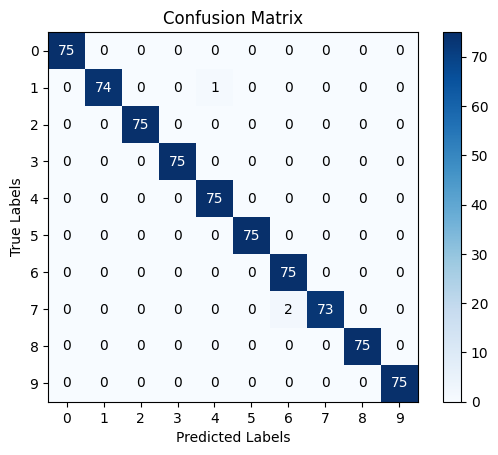

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(predicted.cpu().detach().numpy(), axis=1)
true_labels = test_label

confusion = confusion_matrix(true_labels, predicted_labels)
print(còn·)

# Plot the confusion matrix
plt.imshow(confusion, cmap='Blues')

# Add colorbar and labels
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Add text annotations for each cell
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        if confusion[i, j] > 50:
            text_color = 'white'
        else:
            text_color = 'black'
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color=text_color)

# Set x-axis and y-axis tick labels
tick_labels = np.arange(len(np.unique(true_labels)))
plt.xticks(tick_labels)
plt.yticks(tick_labels)

# Display the plot
plt.show()


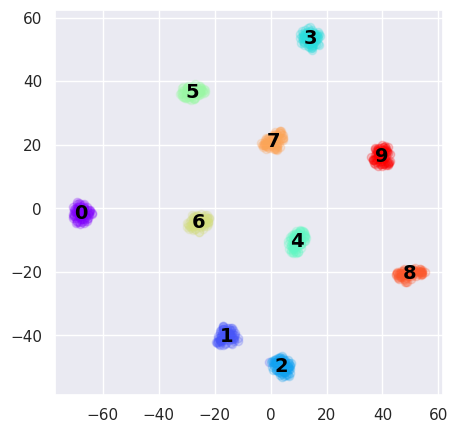

In [ ]:
from keras import backend as K
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
plot_only = len(test_label)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(predicted.cpu().detach().numpy())
p_data = pd.DataFrame(columns=['x', 'y', 'label'])
p_data.x = low_dim_embs[:, 0]
p_data.y = low_dim_embs[:, 1]
p_data.label = test_label[0:plot_only]
utils.plot_with_labels(p_data)